In [ ]:
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt

## Collect and combine individual simulations

In [32]:
# Collect the individual simulation runs
simulation_types = ['configs_sim', 'opt_types_sim']
simulations = {}

for simulation in simulation_types:
    path = os.path.join('data', simulation)
    if not os.path.exists(path):
        os.makedirs(path)
    simulations[simulation] = []
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            simulations[simulation].append(item)

simulations


{'configs_sim': ['2025-04-11-10_31_35',
  '2025-04-11-10_41_00',
  '2025-04-11-10_52_59',
  '2025-04-11-11_12_40',
  '2025-04-11-11_34_29',
  '2025-04-11-11_56_12',
  '2025-04-11-12_46_24',
  '2025-04-11-13_35_25',
  '2025-04-11-14_25_27',
  '2025-04-11-14_33_02',
  '2025-04-11-14_39_32',
  '2025-04-11-14_45_01',
  '2025-04-11-14_56_29',
  '2025-04-11-15_06_32',
  '2025-04-11-15_14_53',
  '2025-04-11-15_25_25',
  '2025-04-11-15_34_55',
  '2025-04-11-15_43_22'],
 'opt_types_sim': ['2025-04-11-10_22_41',
  '2025-04-11-10_24_42',
  '2025-04-11-10_40_40',
  '2025-04-11-11_00_14',
  '2025-04-11-11_02_16',
  '2025-04-11-11_04_16',
  '2025-04-11-11_20_25',
  '2025-04-11-11_42_13',
  '2025-04-11-11_44_10',
  '2025-04-11-11_46_11',
  '2025-04-11-12_02_50',
  '2025-04-11-12_25_03',
  '2025-04-11-12_27_04',
  '2025-04-11-12_29_06',
  '2025-04-11-12_45_39',
  '2025-04-11-13_06_17',
  '2025-04-11-13_08_17',
  '2025-04-11-13_10_16',
  '2025-04-11-13_27_47',
  '2025-04-11-13_50_37']}

In [33]:
results_simulations = pd.DataFrame(columns=['simulation_type', 
                                            'num_intersections', 
                                            'num_cars', 
                                            'num_borders', 
                                            'min_distance', 
                                            'max_distance', 
                                            'optimization_type', 
                                            'steps', 
                                            'total_cars', 
                                            'total_traffic_flow', 
                                            'total_wait_times'])

wait_times_details = pd.DataFrame()

wait_times_grouped = pd.DataFrame(columns=['simulation_type', 
                                           'run_id', 
                                           'car_id', 
                                           'wait_time'])
                                           

In [34]:
for simulation_type in list(simulations.keys()):
    for run in simulations[simulation_type]:

        # create results_simulations DataFrame
        wait_times = pd.read_parquet(f'data/{simulation_type}/{run}/wait_times.parquet')
        traffic = pd.read_parquet(f'data/{simulation_type}/{run}/traffic.parquet')
        config = json.load(open(f'data/{simulation_type}/{run}/config.json'))

        total_num_cars = (wait_times["Car_ID"].max() - wait_times["Car_ID"].min())
        total_traffic_flow = int(traffic[traffic["Lane"] == traffic["Open_Lane"]]["Num_Cars"].sum())
        total_wait_time = int(wait_times["Wait_Time"].sum())

        new_row = pd.DataFrame([{
            'simulation_type': simulation_type,
            'num_intersections': config["num_intersections"],
            'num_cars': config["num_cars"],
            'num_borders': config["num_borders"],
            'min_distance': config["min_distance"],
            'max_distance': config["max_distance"],
            'optimization_type': config["optimization_type"],
            'steps': config["steps"],
            'total_cars': total_num_cars,
            'total_traffic_flow': total_traffic_flow,
            'total_wait_times': total_wait_time
        }])

        results_simulations = pd.concat([results_simulations, new_row], ignore_index=True)

        # create wait_times_details DataFrame
        wait_times = wait_times.rename(columns={'Car_ID': 'car_id', 'Light_ID':'light_id', 'Wait_Time': 'wait_time'})
        wait_times['simulation_type'] = simulation_type
        wait_times['run_id'] = run
        wait_times = wait_times[['simulation_type', 'run_id', 'car_id', 'light_id', 'wait_time']]

        wait_times_details = pd.concat([wait_times_details, wait_times], ignore_index=True)


        # create wait_times_grouped DataFrame
        grouped_wait_times = wait_times.groupby('car_id')['wait_time'].sum().reset_index()
        grouped_wait_times['simulation_type'] = simulation_type
        grouped_wait_times['run_id'] = run
        grouped_wait_times = grouped_wait_times[['simulation_type', 'run_id', 'car_id', 'wait_time']]

        wait_times_grouped = pd.concat([wait_times_grouped, grouped_wait_times], ignore_index=True)


results_simulations.to_parquet('data/simulations_results.parquet', index=False)
wait_times_details.to_parquet('data/wait_times_details.parquet', index=False)
wait_times_grouped.to_parquet('data/wait_times_grouped.parquet', index=False)

## Analyse Simulations

In [35]:
results_simulations = pd.read_parquet('data/simulations_results.parquet')

results_simulations.head(10)

,simulation_type,num_intersections,num_cars,num_borders,min_distance,max_distance,optimization_type,steps,total_cars,total_traffic_flow,total_wait_times
0,configs_sim,25,50,25,9,15,advanced_ml,1000,901,2282,28898
1,configs_sim,25,50,50,9,15,advanced_ml,1000,913,2580,23061
2,configs_sim,25,50,100,9,15,advanced_ml,1000,775,2070,31921
3,configs_sim,50,50,25,9,15,advanced_ml,1000,1005,3452,15155
4,configs_sim,50,50,50,9,15,advanced_ml,1000,972,3282,14937
5,configs_sim,50,50,100,9,15,advanced_ml,1000,1068,3577,13646
6,configs_sim,100,50,25,9,15,advanced_ml,1000,897,3758,12771
7,configs_sim,100,50,50,9,15,advanced_ml,1000,943,3911,10709
8,configs_sim,100,50,100,9,15,advanced_ml,1000,860,3627,12422
9,configs_sim,25,25,50,2,8,advanced_ml,1000,1283,3676,12216


In [36]:
results_simulations['traffic_flow_normalized'] = round((results_simulations['total_traffic_flow'] / results_simulations['total_cars']) / results_simulations['num_intersections'] * 100, 4)
results_simulations['avg_traffic_flow_per_step'] = round(results_simulations['total_traffic_flow'] / results_simulations['steps'], 4)
results_simulations['avg_traffic_flow_per_light'] = round(results_simulations['total_traffic_flow'] / results_simulations['num_intersections'], 4)
results_simulations['avg_traffic_flow_per_step_per_light'] = round(results_simulations['avg_traffic_flow_per_light'] / results_simulations['steps'], 4)

results_simulations['avg_wait_time_per_car'] = round(results_simulations['total_wait_times'] / results_simulations['total_cars'], 4)
results_simulations['avg_wait_time_per_light'] = round(results_simulations['total_wait_times'] / results_simulations['num_intersections'], 4)
results_simulations['avg_wait_time_per_car_per_light'] = round(results_simulations['avg_wait_time_per_light'] / results_simulations['total_cars'], 4)

In [37]:
configs_sim = results_simulations[results_simulations['simulation_type'] == 'configs_sim']
opt_types_sim = results_simulations[results_simulations['simulation_type'] == 'opt_types_sim']

### Optimization Types Simulations

In [38]:
opt_types_sim.head(10)

,simulation_type,num_intersections,num_cars,num_borders,min_distance,max_distance,optimization_type,steps,total_cars,total_traffic_flow,total_wait_times,traffic_flow_normalized,avg_traffic_flow_per_step,avg_traffic_flow_per_light,avg_traffic_flow_per_step_per_light,avg_wait_time_per_car,avg_wait_time_per_light,avg_wait_time_per_car_per_light
18,opt_types_sim,50,250,150,5,15,none,1000,5270,18004,113603,6.8326,18.004,360.08,0.3601,21.5565,2272.06,0.4311
19,opt_types_sim,50,250,150,5,15,simple,1000,5746,20093,99620,6.9937,20.093,401.86,0.4019,17.3373,1992.40,0.3467
20,opt_types_sim,50,250,150,5,15,advanced,1000,5911,20646,97998,6.9856,20.646,412.92,0.4129,16.5789,1959.96,0.3316
21,opt_types_sim,50,250,150,5,15,advanced_ml,1000,4162,14876,130703,7.1485,14.876,297.52,0.2975,31.4039,2614.06,0.6281
22,opt_types_sim,50,250,150,5,15,none,1000,5652,19177,117692,6.7859,19.177,383.54,0.3835,20.8231,2353.84,0.4165
23,opt_types_sim,50,250,150,5,15,simple,1000,5848,21092,98008,7.2134,21.092,421.84,0.4218,16.7592,1960.16,0.3352
24,opt_types_sim,50,250,150,5,15,advanced,1000,5656,20374,96487,7.2044,20.374,407.48,0.4075,17.0592,1929.74,0.3412
25,opt_types_sim,50,250,150,5,15,advanced_ml,1000,3997,13658,152354,6.8341,13.658,273.16,0.2732,38.1171,3047.08,0.7623
26,opt_types_sim,50,250,150,5,15,none,1000,5261,18214,113710,6.9242,18.214,364.28,0.3643,21.6138,2274.20,0.4323
27,opt_types_sim,50,250,150,5,15,simple,1000,6105,20581,100252,6.7423,20.581,411.62,0.4116,16.4213,2005.04,0.3284


In [ ]:
# Getting the average and mean results for each optimization type
average_results_opt_types_sim = opt_types_sim.groupby('optimization_type').agg(
    total_traffic_flow=('total_traffic_flow', 'mean'),
    total_wait_times=('total_wait_times', 'mean'),
    mean_traffic_flow_normalized=('traffic_flow_normalized', 'mean'),
    mean_wait_time_per_car=('avg_wait_time_per_car', 'mean'),
    median_traffic_flow_normalized=('traffic_flow_normalized', 'median'),
    median_wait_time_per_car=('avg_wait_time_per_car', 'median'),
).reset_index()

average_results_opt_types_sim['optimization_type'] = pd.Categorical(
    average_results_opt_types_sim['optimization_type'],
    categories=['none', 'simple', 'advanced_ml', 'advanced'],
    ordered=True
)

average_results_opt_types_sim.sort_values(by='optimization_type', inplace=True)

average_results_opt_types_sim

,optimization_type,total_traffic_flow,total_wait_times,mean_traffic_flow_normalized,mean_wait_time_per_car,median_traffic_flow_normalized,median_wait_time_per_car
2,none,18473.0,114449.4,6.99626,21.67428,6.9242,21.5565
3,simple,20479.2,99292.0,6.97770,16.91402,6.9937,16.9144
1,advanced_ml,14235.6,145638.4,6.98866,35.84402,7.0695,34.6663
0,advanced,20185.8,98166.2,6.93220,16.85470,6.9166,16.8819


Mean traffic flow by optimization type:

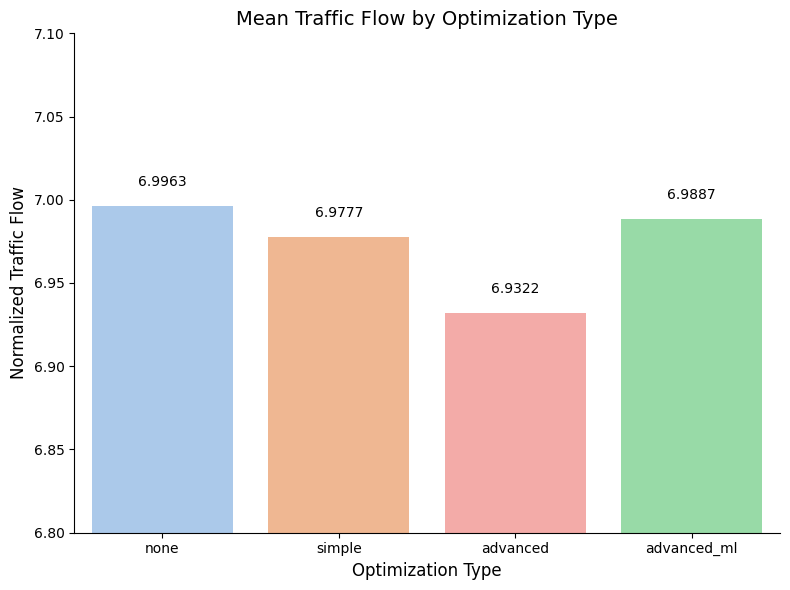

In [ ]:
plt.figure(figsize=(8, 6))  

sns.barplot(
    data=average_results_opt_types_sim,
    x='optimization_type',
    y='mean_traffic_flow_normalized',
    palette='pastel',
    order=['none', 'simple', 'advanced', 'advanced_ml'],
    hue='optimization_type',
    legend=False
)

# Set y-axis limits to zoom in
plt.ylim(6.8, 7.1)

# Improve axis labels and title
plt.xlabel('Optimization Type', fontsize=12)
plt.ylabel('Normalized Traffic Flow', fontsize=12)
plt.title('Mean Traffic Flow by Optimization Type', fontsize=14)

# Add values on top of bars, rounded with 4 decimal zeros
for bar in plt.gca().patches:
    height = bar.get_height()
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,  # Small padding
        f'{height:.4f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

sns.despine()  
plt.tight_layout()
plt.show()


Mean Waiting Time by optimization type

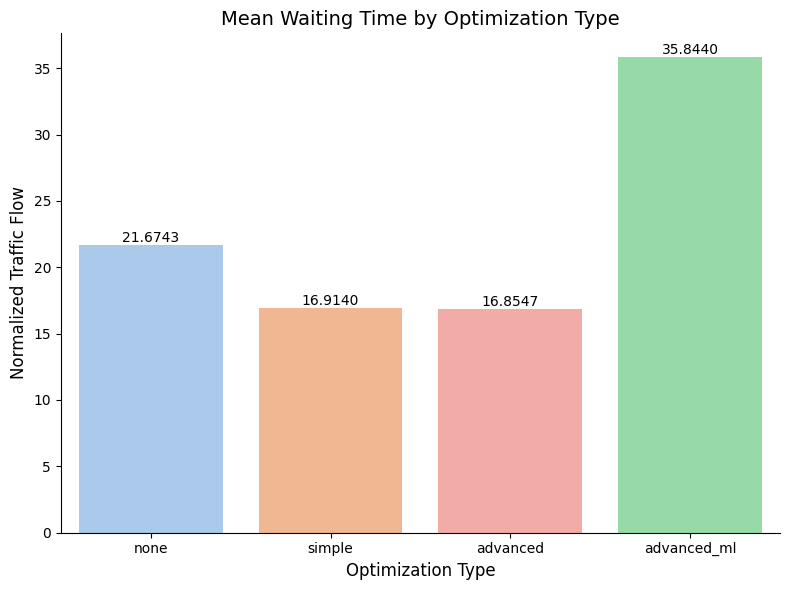

In [ ]:
plt.figure(figsize=(8, 6))  
sns.barplot(
    data=average_results_opt_types_sim,
    x='optimization_type',
    y='mean_wait_time_per_car',
    palette='pastel',
    order=['none', 'simple', 'advanced', 'advanced_ml'],
    hue='optimization_type',
    legend=False
)

# Improve axis labels and title
plt.xlabel('Optimization Type', fontsize=12)
plt.ylabel('Normalized Traffic Flow', fontsize=12)
plt.title('Mean Waiting Time by Optimization Type', fontsize=14)


# Add values on top of bars, rounded with 4 decimal zeros
for bar in plt.gca().patches:
    height = bar.get_height()
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,  # Small padding
        f'{height:.4f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

sns.despine() 
plt.tight_layout()
plt.show()


#### Distribution of total wait time per optimization type

Text(0.5, 1.0, 'Average Wait Time per Car by Optimization Type')

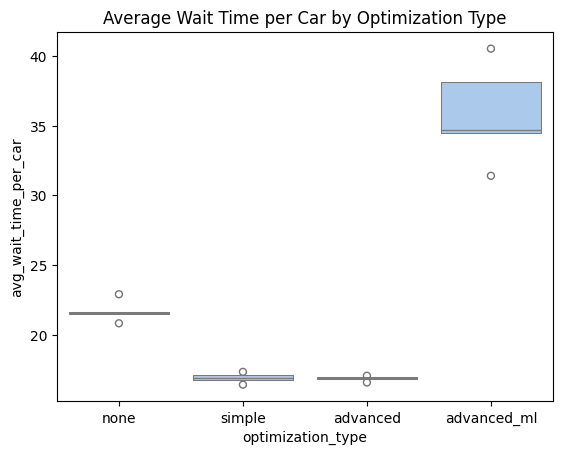

In [40]:
sns.boxenplot(data=opt_types_sim, 
              x='optimization_type', 
              y='avg_wait_time_per_car', 
              palette="pastel", 
              hue='num_intersections', 
              legend=False,
              showfliers=True).set_title('Average Wait Time per Car by Optimization Type')

Text(0.5, 1.0, 'Traffic Flow per Car by Optimization Type')

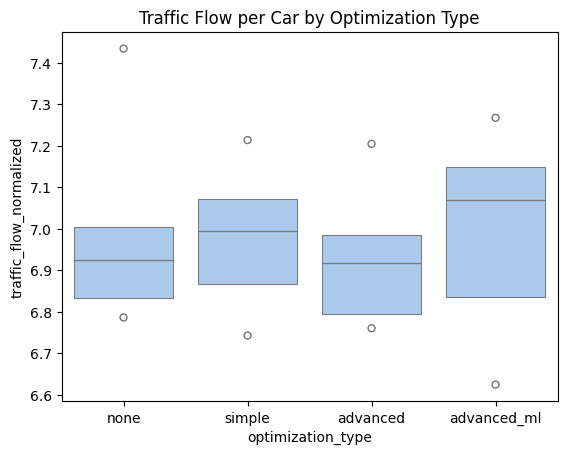

In [41]:
sns.boxenplot(data=opt_types_sim, 
              x='optimization_type', 
              y='traffic_flow_normalized', 
              palette="pastel", 
              hue='num_intersections', 
              legend=False,
              showfliers=True).set_title('Traffic Flow per Car by Optimization Type')

#### Distribution of wait times per car

In [42]:
wait_times_grouped = pd.read_parquet('data/wait_times_grouped.parquet')
wait_times_grouped = wait_times_grouped[wait_times_grouped['simulation_type'] == 'opt_types_sim'].reset_index(drop=True)
wait_times_grouped

,simulation_type,run_id,car_id,wait_time
0,opt_types_sim,2025-04-11-10_22_41,51,11
1,opt_types_sim,2025-04-11-10_22_41,52,20
2,opt_types_sim,2025-04-11-10_22_41,53,13
3,opt_types_sim,2025-04-11-10_22_41,54,18
4,opt_types_sim,2025-04-11-10_22_41,55,25
...,...,...,...,...
102491,opt_types_sim,2025-04-11-13_50_37,3742,2
102492,opt_types_sim,2025-04-11-13_50_37,3770,1
102493,opt_types_sim,2025-04-11-13_50_37,3771,9
102494,opt_types_sim,2025-04-11-13_50_37,3844,3


In [43]:
wait_times_grouped.describe()

,car_id,wait_time
count,102496.000000,102496.000000
mean,2666.484234,22.320188
std,1561.708614,18.373311
min,51.000000,0.000000
25%,1332.000000,9.000000
50%,2613.000000,18.000000
75%,3905.000000,30.000000
max,6156.000000,157.000000


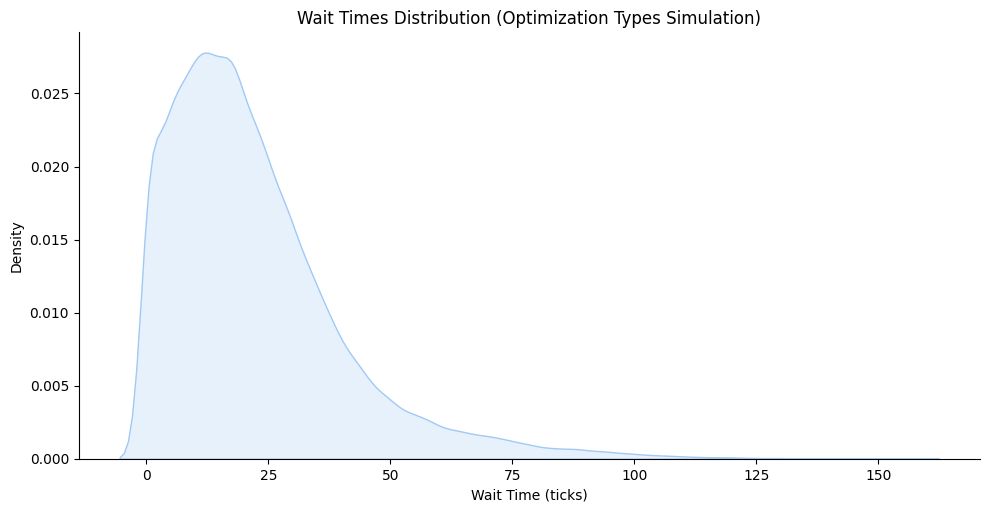

In [44]:
sns.displot(data=wait_times_grouped,
             x='wait_time', 
             hue='simulation_type', 
             kind='kde', 
             fill=True, 
             palette="pastel", 
             height=5, 
             aspect=2,
             legend=False).set(title='Wait Times Distribution (Optimization Types Simulation)').set_axis_labels('Wait Time (ticks)', 'Density')

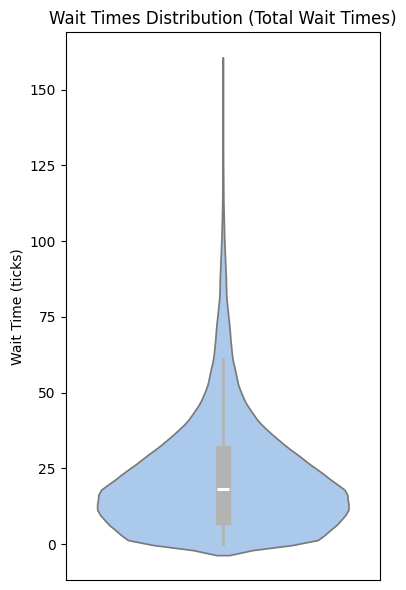

In [105]:
plt.figure(figsize=(4, 6))

sns.violinplot(
    data=wait_times_grouped,
    x='simulation_type',
    y='wait_time',
    palette="pastel",
    hue='simulation_type',
    legend=False,
    inner_kws=dict(box_width=11, whis_width=2, color=".7")
).set(
    title='Wait Times Distribution (Total Wait Times)',
    xlabel='',
    ylabel='Wait Time (ticks)'
)
plt.xticks([], [])
plt.tight_layout()
plt.show()


In [46]:
print(f"Numbers of cars in total: {wait_times_grouped.shape[0]}")
print(f"Number of cars with wait time > 30 (75%): {wait_times_grouped[wait_times_grouped['wait_time'] > 30].shape[0]} ({wait_times_grouped[wait_times_grouped['wait_time'] > 30].shape[0] / wait_times_grouped.shape[0] * 100:.2f}%)")
print(f"Number of cars with wait time > 60 (100%): {wait_times_grouped[wait_times_grouped['wait_time'] > 60].shape[0]} ({wait_times_grouped[wait_times_grouped['wait_time'] > 60].shape[0] / wait_times_grouped.shape[0] * 100:.2f}%)")

Numbers of cars in total: 102496
Number of cars with wait time > 30 (75%): 25068 (24.46%)
Number of cars with wait time > 60 (100%): 4649 (4.54%)


#### Distribution of wait times per light

In [47]:
wait_times_details = pd.read_parquet('data/wait_times_details.parquet')
wait_times_details = wait_times_details[wait_times_details['simulation_type'] == 'opt_types_sim'].reset_index(drop=True)

In [48]:
wait_times_details.describe()

,car_id,light_id,wait_time
count,361624.000000,361624.000000,361624.000000
mean,2656.156353,24.120213,6.326267
std,1557.795480,14.216550,9.504306
min,51.000000,1.000000,0.000000
25%,1323.000000,12.000000,0.000000
50%,2602.000000,23.000000,4.000000
75%,3891.000000,36.000000,9.000000
max,6156.000000,50.000000,135.000000


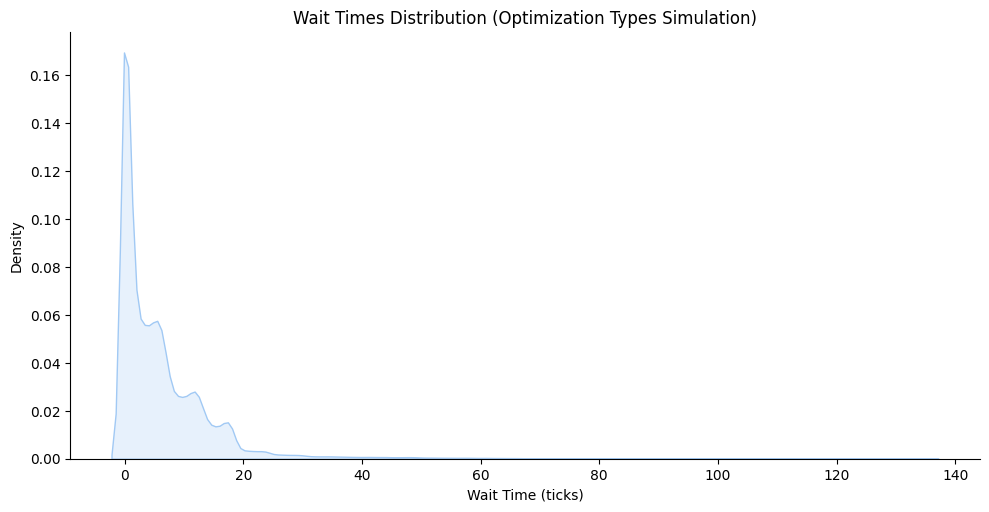

In [49]:
sns.displot(data=wait_times_details,
             x='wait_time', 
             hue='simulation_type', 
             kind='kde', 
             fill=True, 
             palette="pastel", 
             height=5, 
             aspect=2,
             legend=False).set(title='Wait Times Distribution (Optimization Types Simulation)').set_axis_labels('Wait Time (ticks)', 'Density')

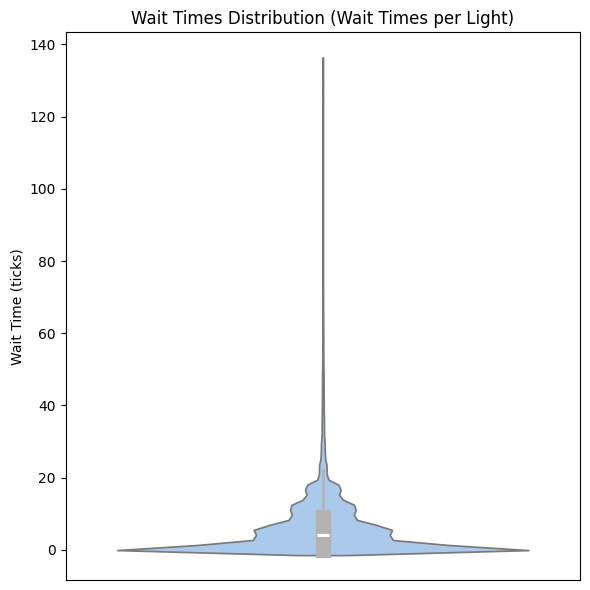

In [106]:
plt.figure(figsize=(6, 6))

sns.violinplot(
    data=wait_times_details,
    x='simulation_type',
    y='wait_time',
    palette="pastel",
    hue='simulation_type',
    legend=False,
    inner_kws=dict(box_width=11, whis_width=2, color=".7")
).set(
    title='Wait Times Distribution (Wait Times per Light)',
    xlabel='',
    ylabel='Wait Time (ticks)'
)
plt.xticks([], [])
plt.tight_layout()
plt.show()


In [51]:
print(f"Numbers of cars in total: {wait_times_details.shape[0]}")
print(f"Number of cars with wait time > 9 (75%): {wait_times_details[wait_times_details['wait_time'] > 30].shape[0]} ({wait_times_details[wait_times_details['wait_time'] > 30].shape[0] / wait_times_details.shape[0] * 100:.2f}%)")
print(f"Number of cars with wait time > 20 (100%): {wait_times_details[wait_times_details['wait_time'] > 60].shape[0]} ({wait_times_details[wait_times_details['wait_time'] > 60].shape[0] / wait_times_details.shape[0] * 100:.2f}%)")

Numbers of cars in total: 361624
Number of cars with wait time > 9 (75%): 8965 (2.48%)
Number of cars with wait time > 20 (100%): 2003 (0.55%)


### Config Simulations

In [60]:
configs_sim_clean = configs_sim[['num_intersections',
                                 'num_cars', 
                                 'num_borders', 
                                 'min_distance', 
                                 'max_distance', 
                                 'traffic_flow_normalized',
                                 'avg_wait_time_per_car_per_light',
                                 'total_cars',
                                 'total_traffic_flow',
                                 'total_wait_times']].copy()

configs_sim_clean.rename(columns={'avg_wait_time_per_car_per_light' : 'wait_time_normalized'}, inplace=True)
configs_sim_clean

,num_intersections,num_cars,num_borders,min_distance,max_distance,traffic_flow_normalized,wait_time_normalized,total_cars,total_traffic_flow,total_wait_times
0,25,50,25,9,15,10.1310,1.2829,901,2282,28898
1,25,50,50,9,15,11.3034,1.0103,913,2580,23061
2,25,50,100,9,15,10.6839,1.6475,775,2070,31921
3,50,50,25,9,15,6.8697,0.3016,1005,3452,15155
4,50,50,50,9,15,6.7531,0.3073,972,3282,14937
5,50,50,100,9,15,6.6985,0.2555,1068,3577,13646
6,100,50,25,9,15,4.1895,0.1424,897,3758,12771
7,100,50,50,9,15,4.1474,0.1136,943,3911,10709
8,100,50,100,9,15,4.2174,0.1444,860,3627,12422
9,25,25,50,2,8,11.4606,0.3809,1283,3676,12216


#### Config Simulation: influence of num_intersections and num_borders

In [61]:
configs_sim_intersections_borders = configs_sim_clean[configs_sim_clean.index <= 8].copy()
configs_sim_intersections_borders = configs_sim_intersections_borders[['num_intersections', 'num_borders', 'traffic_flow_normalized', 'wait_time_normalized']].copy()
configs_sim_intersections_borders

,num_intersections,num_borders,traffic_flow_normalized,wait_time_normalized
0,25,25,10.1310,1.2829
1,25,50,11.3034,1.0103
2,25,100,10.6839,1.6475
3,50,25,6.8697,0.3016
4,50,50,6.7531,0.3073
5,50,100,6.6985,0.2555
6,100,25,4.1895,0.1424
7,100,50,4.1474,0.1136
8,100,100,4.2174,0.1444


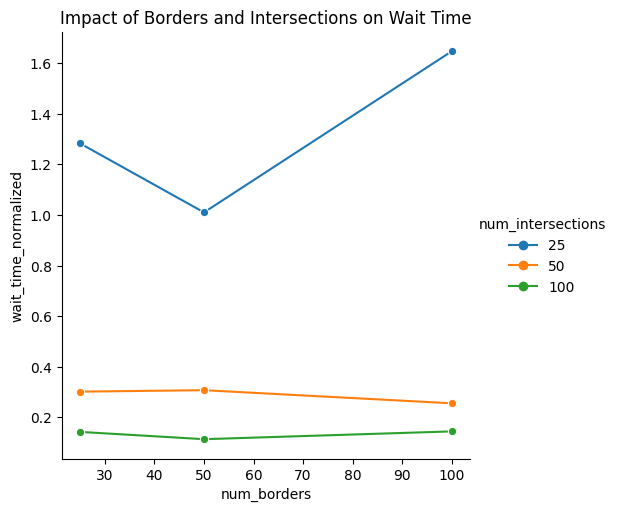

In [83]:
sns.relplot(
    data=configs_sim_intersections_borders,
    x='num_borders',
    y='wait_time_normalized',
    kind='line',
    hue='num_intersections',
    marker='o',
    palette='tab10'
).set(title='Impact of Borders and Intersections on Wait Time')


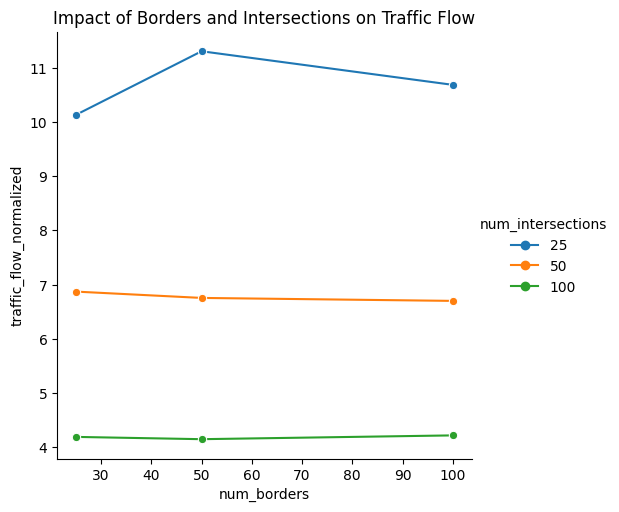

In [84]:
sns.relplot(
    data=configs_sim_intersections_borders,
    x='num_borders',
    y='traffic_flow_normalized',
    kind='line',
    hue='num_intersections',
    marker='o',
    palette='tab10'
).set(title='Impact of Borders and Intersections on Traffic Flow')


#### Config Simulation: influence of num_cars and distance

In [80]:
configs_sim_cars_distance = configs_sim_clean[configs_sim_clean.index > 8].copy()
configs_sim_cars_distance = configs_sim_cars_distance[['num_cars', 'min_distance', 'max_distance', 'traffic_flow_normalized', 'wait_time_normalized']].copy()
configs_sim_cars_distance['distance'] = configs_sim_cars_distance['min_distance'].astype(str) + '-' + configs_sim_cars_distance['max_distance'].astype(str)
configs_sim_cars_distance = configs_sim_cars_distance[['num_cars', 'distance', 'traffic_flow_normalized', 'wait_time_normalized']].copy()
configs_sim_cars_distance

,num_cars,distance,traffic_flow_normalized,wait_time_normalized
9,25,2-8,11.4606,0.3809
10,50,2-8,11.1522,0.4482
11,100,2-8,11.4404,0.5635
12,25,9-15,10.6200,1.8456
13,50,9-15,11.2458,1.6093
14,100,9-15,11.2429,0.8696
15,25,16-22,10.7418,0.5087
16,50,16-22,11.4300,0.5995
17,100,16-22,10.1480,0.6497


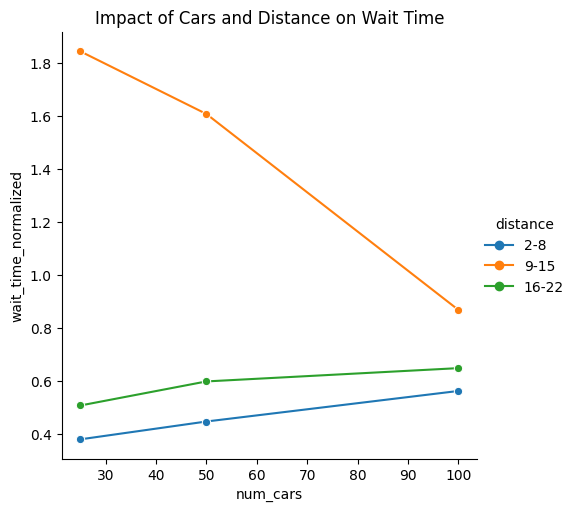

In [85]:
sns.relplot(
    data=configs_sim_cars_distance,
    x='num_cars',
    y='wait_time_normalized',
    kind='line',
    hue='distance',
    marker='o',
    palette='tab10'
).set(title='Impact of Cars and Distance on Wait Time')


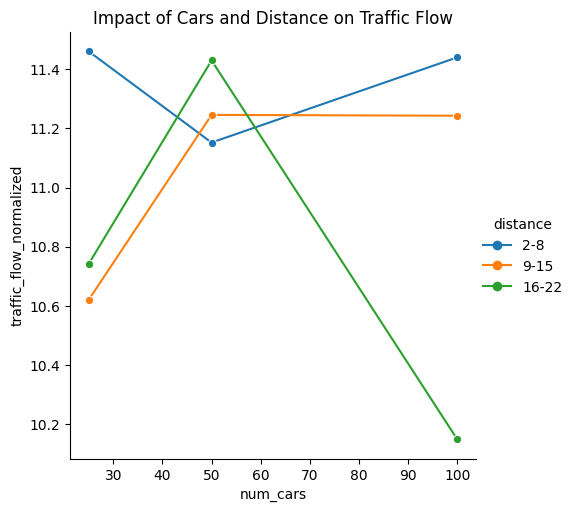

In [86]:
sns.relplot(
    data=configs_sim_cars_distance,
    x='num_cars',
    y='traffic_flow_normalized',
    kind='line',
    hue='distance',
    marker='o',
    palette='tab10'
).set(title='Impact of Cars and Distance on Traffic Flow')
